In [ ]:
!pip install asyncpraw
!pip install nest_asyncio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 4.3 MB/s eta 0:00:00


# Phase 1: Data Extraction from Reddit
In this phase, we extract posts related to electric vehicles from relevant subreddits using the Reddit API. We use the `asyncpraw` library to interact with the Reddit API asynchronously, ensuring efficient data collection.


In [ ]:
import asyncpraw
import pandas as pd
import asyncio
import nest_asyncio

nest_asyncio.apply()

# Reddit API credentials
reddit = asyncpraw.Reddit(client_id='P6aqmHjqxlAF000Mx0-3ow',
                          client_secret='ow8Yq-fgL7Lqgh_Ihdw6q6iESW6Awg',
                          user_agent='python:my_reddit_app:v1.0 (by /u/Ok_Western_8516)')


In [ ]:
async def fetch_posts(subreddit_name, query, limit=1000):
    subreddit = await reddit.subreddit(subreddit_name)
    posts = []
    async for submission in subreddit.search(query, limit=limit):
        posts.append([submission.id, submission.created_utc, submission.title, submission.selftext, submission.score, submission.num_comments, submission.author.name])
    return pd.DataFrame(posts, columns=['id', 'created_utc', 'title', 'selftext', 'score', 'num_comments', 'author'])

In [ ]:
subreddits = ['electricvehicles', 'teslamotors', 'EVnews']
query = 'electric vehicle'
posts_df = pd.DataFrame()

async def main():
    global posts_df
    for subreddit_name in subreddits:
        posts = await fetch_posts(subreddit_name, query, limit=500)
        posts_df = pd.concat([posts_df, posts], ignore_index=True)
    posts_df.to_csv('ev_posts.csv', index=False)
    print(posts_df.head())
await main()

        id   created_utc                                              title  \
0  198ve0x  1.705494e+09  I think it's time to update the narrative on w...   
1  1ddq2v5  1.718142e+09  GM's electric vehicle growth is 'outpacing eve...   
2  193y8ot  1.704967e+09  Hyundai's Electric Vehicle Push Is Absolutely ...   
3  1ditvwp  1.718726e+09  How electric vehicles are lowering electricity...   
4  1dr46n2  1.719640e+09             C-SPAN - Exchange on Electric Vehicles   

                                            selftext  score  num_comments  \
0  Hey guys, I posted something similar in the Ri...    829           965   
1  Relevant to some comments made earlier today o...    686           325   
2                                                       695           375   
3                                                       406           131   
4                                                       448           174   

       author  
0    vjarizpe  
1  MN-Car-Guy  
2  Bravadette 

# Phase 2: Data Preprocessing
In this phase, we preprocess the extracted Reddit posts to prepare them for analysis. The preprocessing steps include:
- Converting the creation time to a datetime format.
- Combining the title and selftext of each post into a single text column.
- Removing URLs, special characters, and stopwords from the text.


In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('stopwords')
nltk.download('punkt')

df = pd.read_csv('ev_posts.csv')

df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
df['text'] = df['title'].fillna('') + ' ' + df['selftext'].fillna('')

def preprocess_text(text):
  text = re.sub(r'http\S+', '', text)
  text = re.sub(r'[^A-Za-z\s]', '', text)
  tokens = word_tokenize(text)
  tokens = [word for word in tokens if word.lower() not in stopwords.words('english')]
  return ' '.join(tokens)

df['clean_text'] = df['text'].apply(lambda x: preprocess_text(str(x)))

df.to_csv('preprocessed_ev_posts.csv', index=False)


print(df.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


        id         created_utc  \
0  198ve0x 2024-01-17 12:25:42   
1  1ddq2v5 2024-06-11 21:45:26   
2  193y8ot 2024-01-11 10:04:26   
3  1ditvwp 2024-06-18 15:47:09   
4  1dr46n2 2024-06-29 05:43:47   

                                               title  \
0  I think it's time to update the narrative on w...   
1  GM's electric vehicle growth is 'outpacing eve...   
2  Hyundai's Electric Vehicle Push Is Absolutely ...   
3  How electric vehicles are lowering electricity...   
4             C-SPAN - Exchange on Electric Vehicles   

                                            selftext  score  num_comments  \
0  Hey guys, I posted something similar in the Ri...    829           965   
1  Relevant to some comments made earlier today o...    686           325   
2                                                NaN    695           375   
3                                                NaN    406           131   
4                                                NaN    448           174

# Phase 3: Visualization of Data Distribution
In this phase, we visualize the distribution of the posts over time and generate a word cloud to understand the common terms used in the discussions.


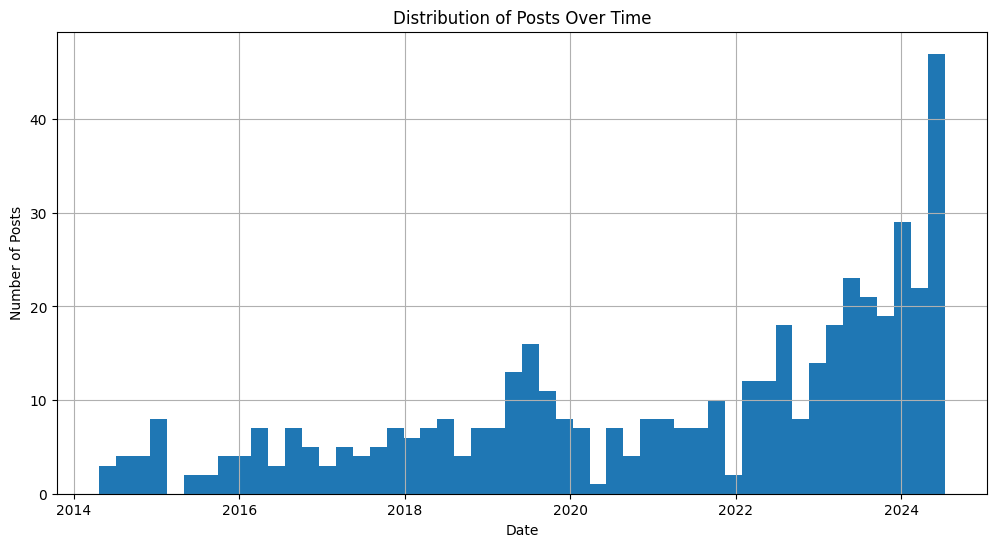

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Visualization: Distribution of posts over time
plt.figure(figsize=(12, 6))
df['created_utc'].hist(bins=50)
plt.title('Distribution of Posts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.show()

## word cloud

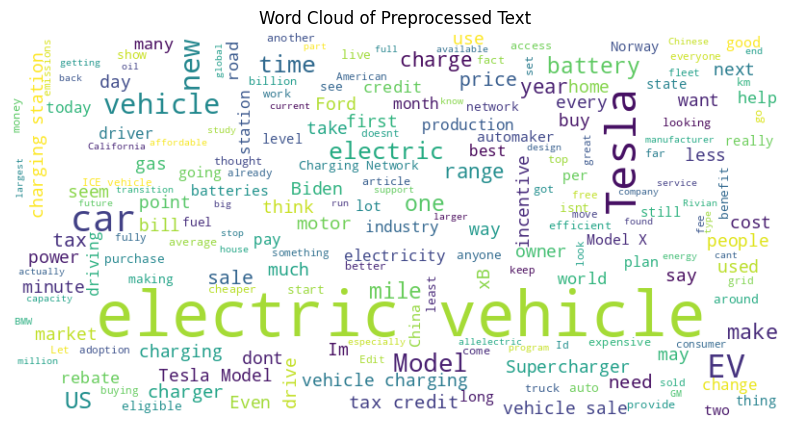

In [ ]:
text = ' '.join(df['clean_text'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Preprocessed Text')
plt.axis('off')
plt.show()

# Phase 4: Information Retrieval
In this phase, we perform information retrieval to find the most relevant posts based on specific queries. We use TF-IDF vectorization and cosine similarity to rank the posts.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

df = pd.read_csv('preprocessed_ev_posts.csv')
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_text'])

Top posts for query 'electric vehicle':
                                                 title selftext
271  My current electric vehicle and my dream elect...      NaN
139         The Best Electric Vehicle Chargers Of 2024      NaN
263  PSA: We are excited for all the new Model 3 ow...      NaN
142            Cars.com: Best Electric Vehicle of 2024      NaN
57     Ranked: Electric Vehicle Sales by Model in 2023      NaN
144            US electric vehicle sales surge in 2022      NaN
205  14% of Americans Want Their Next Vehicle to Be...      NaN
236  Gov. Greg Abbott signs electric vehicle fee in...      NaN
330   Model Y - Cars.com Best Electric Vehicle of 2022      NaN
390     Electric vehicle sales are running out of gas.      NaN


<ipython-input-9-eeeb00231d9e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_posts['query'] = query


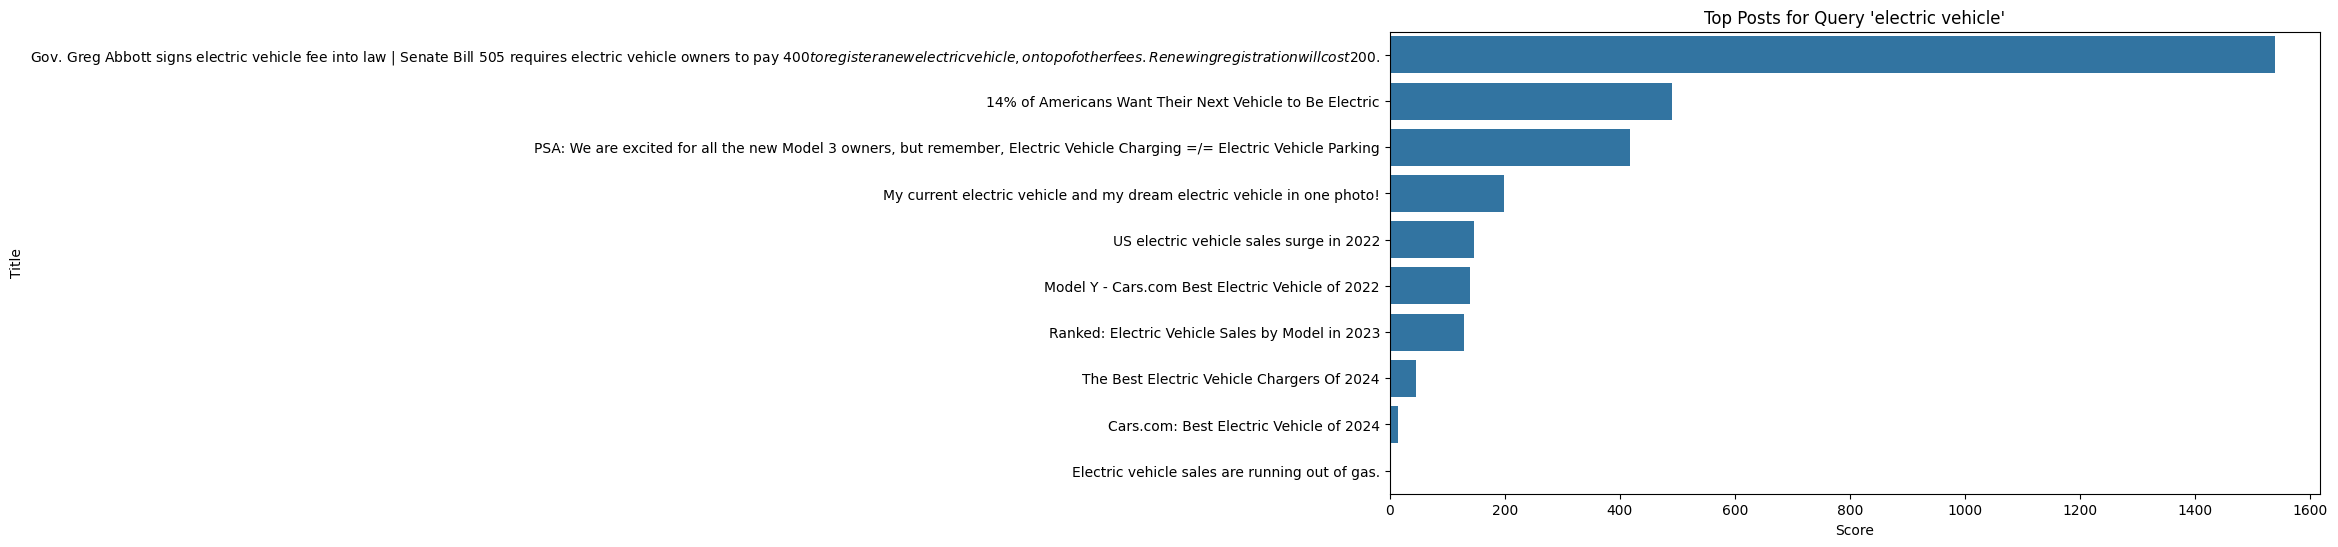

Top posts for query 'EV':
                                                 title  \
331  No electric vehicles on the market today quali...   
77   DeWalt EV Chargers Set to Enter Electric Vehic...   
244  Electric vehicle owners are fed up with broken...   
368  US Senate passes amendment that removes eligib...   
149  Charging points every 60 km for light electric...   
275  White House unlocks $4.5 billion for electric ...   
161  Rivian secures massive Georgia land deal for n...   
154  America Is Quickly Splitting Into Electric Veh...   
79   General Motors Executive Says The Chevrolet Eq...   
190  The EV Politics Project: Getting More Republic...   

                                              selftext  
331                                                NaN  
77                                                 NaN  
244                                                NaN  
368  https://www.washingtonpost.com/business/on-sma...  
149  Good news for EV drivers in Europe. A move to

<ipython-input-9-eeeb00231d9e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_posts['query'] = query


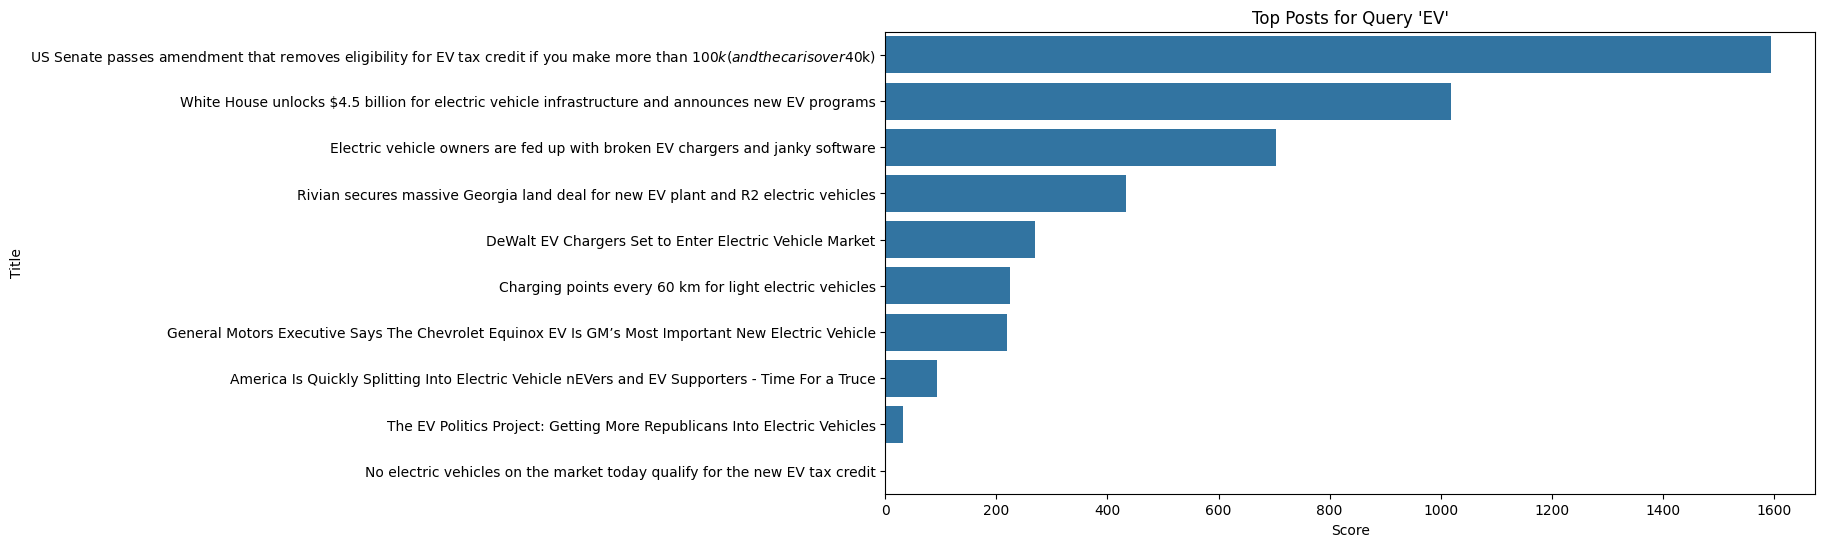

Top posts for query 'Tesla':
                                                 title selftext
280  Tesla Electric offering a home electricity pla...      NaN
443     Should a Porsche Electric Vehicle Worry Tesla?      NaN
428  Tesla Owners Group: Buying into more than just...      NaN
121  Tesla and Nissan Make the Most Reliable Electr...      NaN
346  Tesla Model 3 is Europe's best-selling electri...      NaN
406        Electric Vehicles are Dead, Long Live Tesla      NaN
354  Germany subsidizing some electric vehicles, bu...      NaN
319  Tesla Model 3 could set the charging standard ...      NaN
7    Tesla announces production of its 6 millionth ...      NaN
394  Battery Cylindrical Cell Analysis: 4680 - 2170...      NaN


<ipython-input-9-eeeb00231d9e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_posts['query'] = query


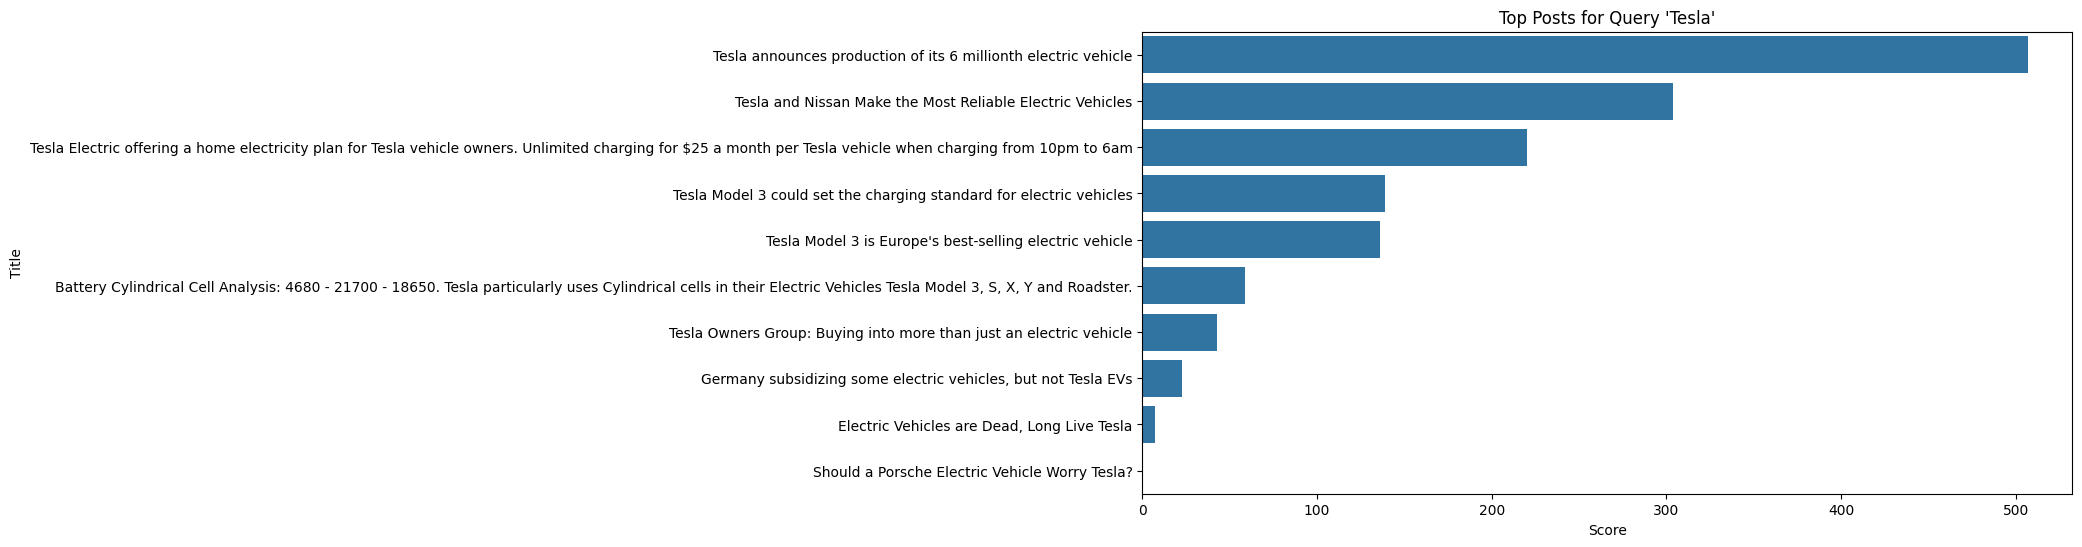

In [ ]:
queries = ["electric vehicle", "EV", "Tesla"]
for query in queries:
    query_vec = vectorizer.transform([query])
    results = cosine_similarity(query_vec, X).flatten()
    top_indices = results.argsort()[-10:][::-1]
    top_posts = df.iloc[top_indices]
    print(f"Top posts for query '{query}':")
    print(top_posts[['title', 'selftext']])

    # Visualization: Top Posts for Each Query
    top_posts['query'] = query
    plt.figure(figsize=(12, 6))
    sns.barplot(x='score', y='title', data=top_posts.sort_values('score', ascending=False))
    plt.title(f"Top Posts for Query '{query}'")
    plt.xlabel('Score')
    plt.ylabel('Title')
    plt.show()


# Phase 5: Named Entity Recognition (NER)
In this phase, we use SpaCy to extract named entities from the posts. We focus on extracting geographic locations (GPE entities) to understand the geographic distribution of the discussions.


In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
def extract_locations(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ == 'GPE']

df['locations'] = df['clean_text'].apply(lambda x: extract_locations(x))

print(df[['clean_text', 'locations']].head())



                                          clean_text         locations
0  think time update narrative people buy electri...  [Texas, Houston]
1  GMs electric vehicle growth outpacing everybod...                []
2  Hyundais Electric Vehicle Push Absolutely Working                []
3  electric vehicles lowering electricity bills e...                []
4                   CSPAN Exchange Electric Vehicles                []


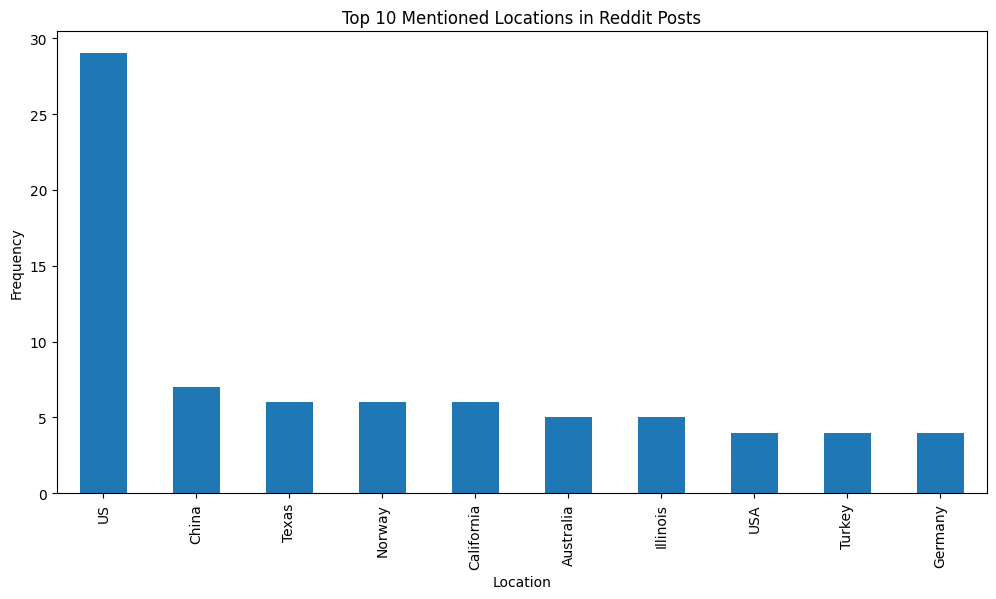

In [ ]:
location_counts = df['locations'].explode().value_counts()

# Visualize the top locations
location_counts.head(10).plot(kind='bar', figsize=(12, 6))
plt.title('Top 10 Mentioned Locations in Reddit Posts')
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.show()

entities
(Tesla, ORG)        79
(EV, ORG)           43
(US, GPE)           29
(one, CARDINAL)     19
(first, ORDINAL)    19
Name: count, dtype: int64


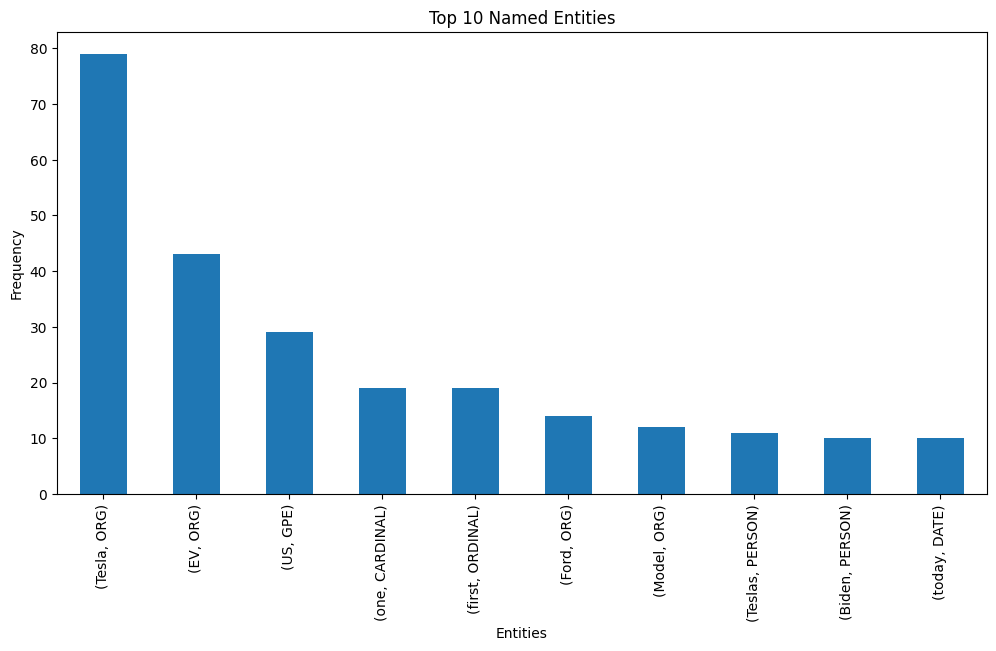

In [ ]:
df['entities'] = df['clean_text'].apply(lambda x: [(ent.text, ent.label_) for ent in nlp(x).ents])
entity_freq = df['entities'].explode().value_counts()
print(entity_freq.head())

# Visualization: Top Named Entities
entity_freq.head(10).plot(kind='bar', figsize=(12, 6))
plt.title('Top 10 Named Entities')
plt.xlabel('Entities')
plt.ylabel('Frequency')
plt.show()


# Phase 6: Sentiment Analysis
In this phase, we perform sentiment analysis on the posts using the Hugging Face `transformers` library. We analyze the sentiment distribution and visualize how sentiment changes over time.


In [ ]:
from transformers import pipeline, DistilBertTokenizerFast

sentiment_pipeline = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def truncate_text(text, max_length=512):
    encoded_input = tokenizer(text, truncation=True, max_length=max_length, return_tensors='pt')
    return tokenizer.decode(encoded_input['input_ids'][0], skip_special_tokens=True)

# Perform sentiment analysis
df['truncated_text'] = df['clean_text'].apply(lambda x: truncate_text(x))
df['sentiment'] = df['truncated_text'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

df.to_csv('sentiment_ev_posts.csv', index=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

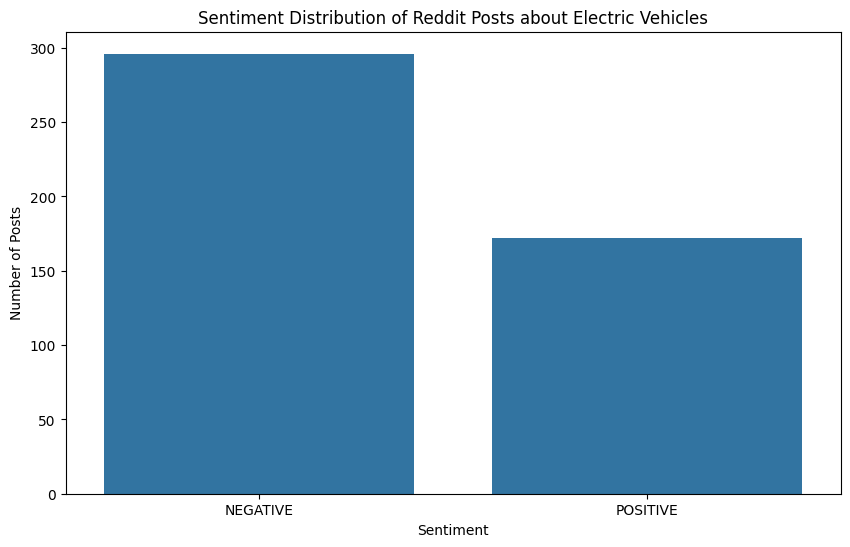

In [ ]:
# Visualization: Sentiment Distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution of Reddit Posts about Electric Vehicles')
plt.xlabel('Sentiment')
plt.ylabel('Number of Posts')
plt.show()

<Figure size 1200x600 with 0 Axes>

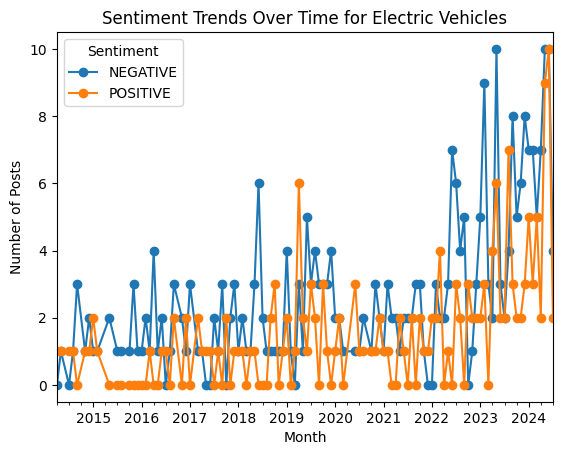

In [ ]:
# Visualization: Sentiment Trends Over Time
df['created_utc'] = pd.to_datetime(df['created_utc'])
df['month'] = df['created_utc'].dt.to_period('M')
sentiment_trends = df.groupby(['month', 'sentiment']).size().unstack().fillna(0)

plt.figure(figsize=(12, 6))
sentiment_trends.plot(kind='line', marker='o')
plt.title('Sentiment Trends Over Time for Electric Vehicles')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.legend(title='Sentiment')
plt.show()

# Phase 7: Topic Modeling with Gensim and pyLDAvis
In this phase, we perform topic modeling on the posts using Gensim's LDA model and visualize the topics using pyLDAvis.


In [ ]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 24.7 MB/s eta 0:00:00


In [ ]:
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models
import nltk

stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return tokens

df['tokens'] = df['clean_text'].apply(preprocess)

dictionary = corpora.Dictionary(df['tokens'])

corpus = [dictionary.doc2bow(tokens) for tokens in df['tokens']]

lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42)

for i, topic in lda_model.show_topics(formatted=False):
    print(f'Topic {i}:')
    print([word for word, _ in topic])

pyLDAvis.enable_notebook()
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)


Topic 0:
['electric', 'vehicle', 'vehicles', 'tesla', 'model', 'ev', 'one', 'car', 'charge', 'sales']
Topic 1:
['electric', 'vehicles', 'vehicle', 'cars', 'tesla', 'model', 'car', 'miles', 'sales', 'would']
Topic 2:
['electric', 'vehicle', 'vehicles', 'new', 'like', 'tesla', 'model', 'miles', 'years', 'also']
Topic 3:
['electric', 'vehicles', 'vehicle', 'tesla', 'tax', 'charging', 'new', 'credit', 'us', 'model']
Topic 4:
['electric', 'vehicle', 'tesla', 'charging', 'vehicles', 'network', 'model', 'ev', 'gas', 'like']


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
!pip install community

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Phase 8: Network analysis
In this phase, we analyze user interactions within the Reddit discussions and identify influential users and sub-communities using NetworkX and the Louvain method for community detection.


In [ ]:
import asyncpraw
import pandas as pd
import asyncio
import nest_asyncio
import time
import json

nest_asyncio.apply()

# Reddit API credentials
reddit = asyncpraw.Reddit(client_id='P6aqmHjqxlAF000Mx0-3ow',
                          client_secret='ow8Yq-fgL7Lqgh_Ihdw6q6iESW6Awg',
                          user_agent='python:my_reddit_app:v1.0 (by /u/Ok_Western_8516)')

async def fetch_comments(subreddit_name, query, post_limit=20, comment_limit=20):
    subreddit = await reddit.subreddit(subreddit_name)
    posts = []
    comments_dict = {}
    async for submission in subreddit.search(query, limit=post_limit):
        await submission.load()
        post_author = submission.author.name if submission.author else 'Unknown'
        posts.append([submission.id, submission.created_utc, submission.title, submission.selftext, submission.score, submission.num_comments, post_author])
        submission_comments = []
        await submission.comments.replace_more(limit=None)
        count = 0
        for comment in submission.comments.list():
            if count >= comment_limit:
                break
            comment_author = comment.author.name if comment.author else 'Unknown'
            submission_comments.append({'author': comment_author, 'body': comment.body, 'score': comment.score, 'parent_id': comment.parent_id, 'id': comment.id})
            count += 1
        comments_dict[submission.id] = submission_comments
    return pd.DataFrame(posts, columns=['id', 'created_utc', 'title', 'selftext', 'score', 'num_comments', 'author']), comments_dict

subreddits = ['electricvehicles', 'teslamotors']
query = 'electric vehicle'
posts_df = pd.DataFrame()
comments_data = {}

async def main():
    global posts_df, comments_data
    for subreddit_name in subreddits:
        try:
            print(f"Fetching posts from {subreddit_name}...")
            posts, comments = await fetch_comments(subreddit_name, query, post_limit=10, comment_limit=5)
            posts_df = pd.concat([posts_df, posts], ignore_index=True)
            comments_data.update(comments)
            print(f"Fetched {len(posts)} posts from {subreddit_name}")
        except Exception as e:
            print(f"Error fetching posts from {subreddit_name}: {e}")
    posts_df.to_csv('ev_posts_with_comments.csv', index=False)
    with open('comments_data.json', 'w') as f:
        json.dump(comments_data, f)
    print(f"Total time taken: {time.time() - start_time} seconds")

start_time = time.time()

# Run the async function
await main()


In [ ]:
import pandas as pd
import networkx as nx
posts_df = pd.read_csv('ev_posts_with_comments.csv')
with open('comments_data.json') as f:
    comments_data = json.load(f)

G = nx.Graph()

for post_id, post_comments in comments_data.items():
    post_author = posts_df.loc[posts_df['id'] == post_id, 'author'].values[0]
    if post_author:
        G.add_node(post_author)
        for comment in post_comments:
            commenter = comment['author']
            if commenter:
                G.add_node(commenter)
                G.add_edge(post_author, commenter)
                # Add edges between commenters in the same thread
                for reply in post_comments:
                    if reply['parent_id'].startswith('t1_'):
                        replier = reply['author']
                        if replier and replier != commenter:
                            G.add_node(replier)
                            G.add_edge(commenter, replier)

# Debugging: Print number of nodes and edges
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of nodes: 106
Number of edges: 98


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


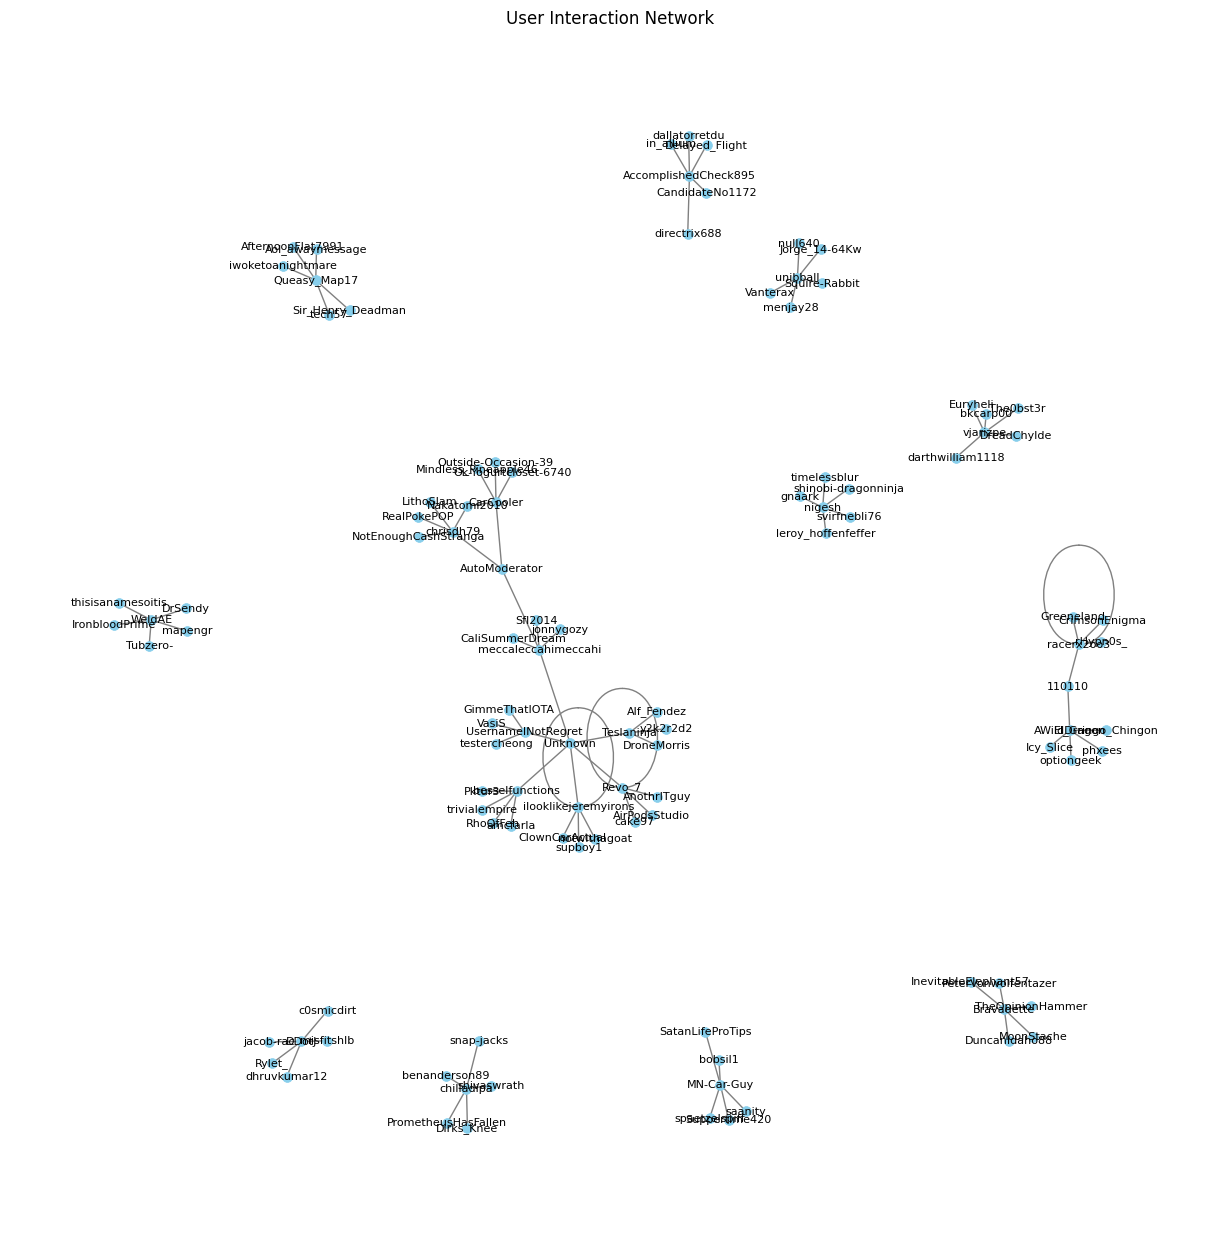

Top 5 Nodes by Degree Centrality: [('Unknown', 0.05714285714285715), ('Revo_7', 0.05714285714285715), ('racerx2oo3', 0.05714285714285715), ('ilooklikejeremyirons', 0.05714285714285715), ('vjarizpe', 0.04761904761904762)]
Top 5 Nodes by Betweenness Centrality: [('Unknown', 0.08608058608058608), ('meccaleccahimeccahi', 0.058424908424908426), ('AutoModerator', 0.044322344322344324), ('besselfunctions', 0.023809523809523808), ('chrisdh79', 0.020604395604395604)]
Top 5 Nodes by Closeness Centrality: [('Unknown', 0.14583333333333331), ('meccaleccahimeccahi', 0.13257575757575757), ('AutoModerator', 0.11217948717948718), ('besselfunctions', 0.110062893081761), ('UsernameINotRegret', 0.10802469135802469)]
Communities detected: {'vjarizpe': 0, 'bkcarp00': 0, 'Euryheli': 0, 'The0bst3r': 0, 'DreadChylde': 0, 'darthwilliam1118': 0, 'MN-Car-Guy': 1, 'saanity': 1, 'spaetzelspiff': 1, 'SatanLifeProTips': 1, 'bobsil1': 1, 'Suppertime420': 1, 'Bravadette': 2, 'TheOpinionHammer': 2, 'PeterVonwolfentazer'

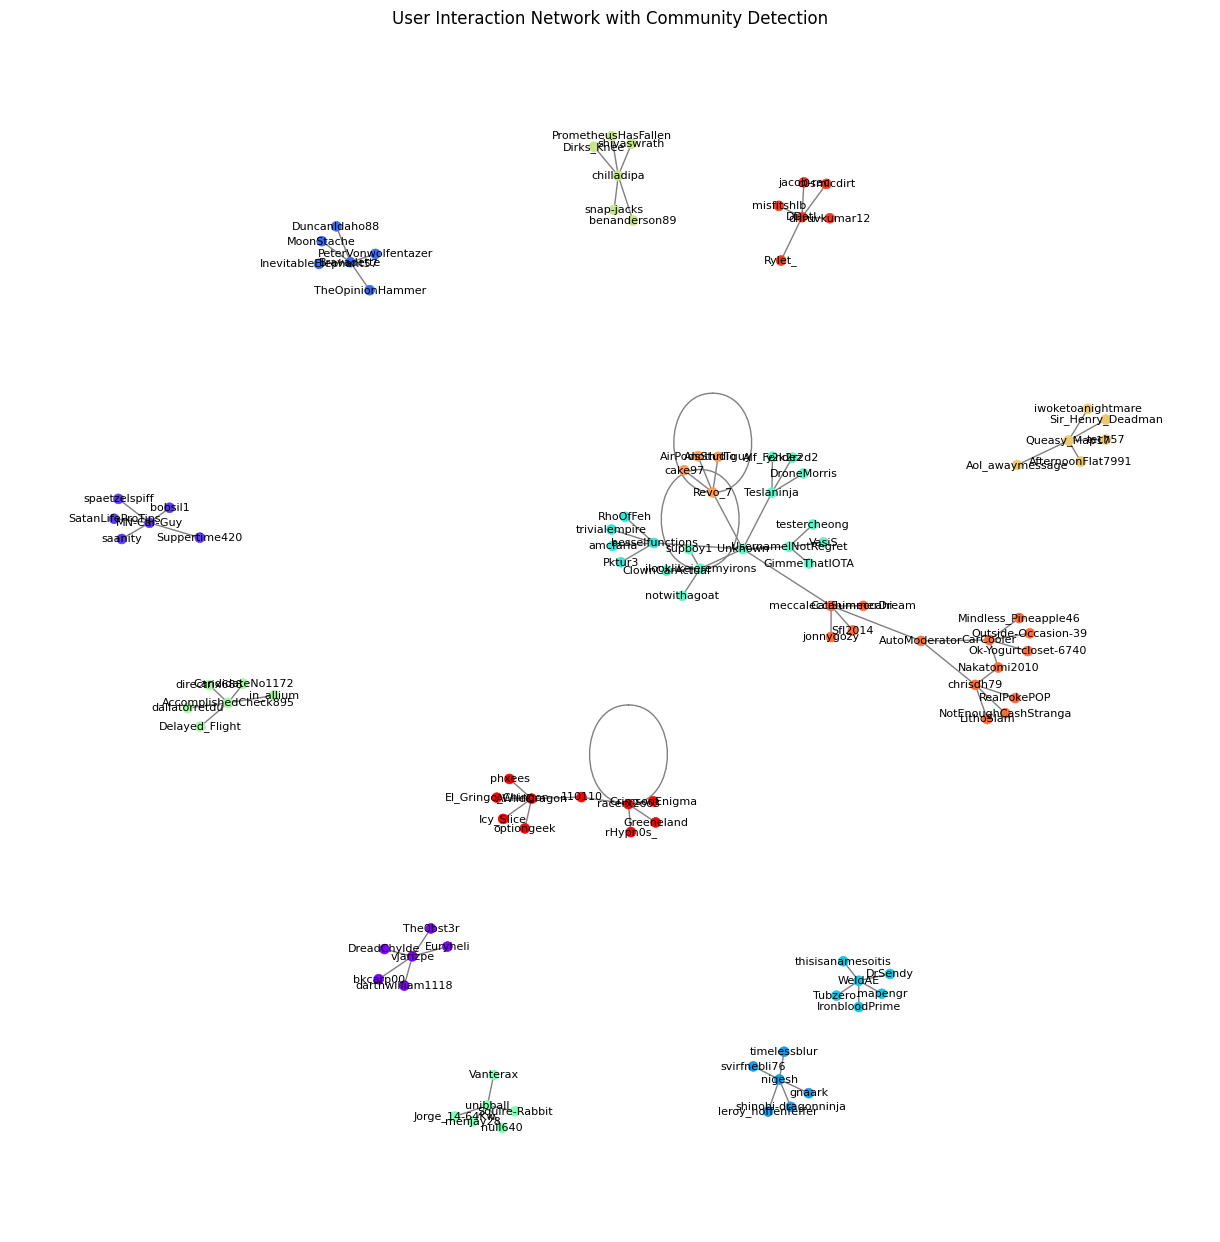

In [ ]:
import matplotlib.pyplot as plt
from community import community_louvain


if G.number_of_nodes() > 0 and G.number_of_edges() > 0:

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=0.1)
    nx.draw(G, pos, with_labels=True, node_size=50, node_color="skyblue", edge_color="gray", linewidths=0.5, font_size=8)
    plt.title('User Interaction Network')
    plt.show()


    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)


    print("Top 5 Nodes by Degree Centrality:", sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5])
    print("Top 5 Nodes by Betweenness Centrality:", sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])
    print("Top 5 Nodes by Closeness Centrality:", sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])


    communities = community_louvain.best_partition(G)
    print("Communities detected:", communities)

    # Plot community structure
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, k=0.1)
    colors = [communities[node] for node in G.nodes()]
    nx.draw(G, pos, node_color=colors, with_labels=True, node_size=50, edge_color="gray", linewidths=0.5, font_size=8, cmap=plt.cm.rainbow)
    plt.title('User Interaction Network with Community Detection')
    plt.show()
else:
    print("No nodes or edges found in the graph.")
